## k-vs-(N-k) Flu ABM Env
Kicking tires on multiplayer instance of Flu ABM with RL learners 

In [1]:
import itertools, importlib, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
# warnings.filterwarnings("ignore")
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (18,7)

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/train_rf_flugame_worker' 

Tensorflow version: 1.13.1


In [2]:
sys.path.append('./embodied_arch')

import embodied as emg
import embodied_indep as emi 
import flumodel_python.flu_env as Fenv
from embodied_misc import ActionPolicyNetwork, SensoriumNetworkTemplate

/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/oosoba/Documents/RAND/Coding/multiagent-ABM/flumodel_python/flu_env_basic.py:43: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  columns=['HCW', 'adaptive', 'vacc.attitude']
/Users/oosoba/Documents/RAND/Coding/multiagent-ABM/flumodel_python/flu_env.py:20: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  columns=['HCW', 'adaptive', 'vacc.attitude']


## Env Setup

In [3]:
exos = [1,2,3,10]  # (np.random.sample(33) < 0.3)

importlib.reload(Fenv);
importlib.reload(emg);
importlib.reload(emi);

# ?Fenv.Flu_env

In [4]:
tf.reset_default_graph()
flu_menv = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
print(flu_menv.actor_count)
print(flu_menv.state_space_size, flu_menv.action_space_size)

4
12 1


### MARL Setup Demo

In [6]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=1e-1)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,), out_dim=out_dim, gamma_reg=5.)

# num_episodes, n_epochs, max_len = (5, 4, 5)
num_episodes, n_epochs, max_len = (10, 400, 25)

In [7]:
flumrf = emi.EmbodiedAgent_IRFB(
    name="flu_mRFB",
    env_=flu_menv,
    alpha_p=5e3, alpha_v=5e2,
    max_episode_length=max_len,
    latentDim=4, 
    actorNN=actor, sensorium=sensor
)
# ??flumrf.play
(flumrf.a_size, flumrf.env.action_space_size)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.


(1, 1)

In [8]:
sess = tf.InteractiveSession()
flumrf.init_graph(sess) # note tboard log dir
saver = tf.train.Saver(max_to_keep=1) 

Tensorboard logs in:  ./log/train_flu_mRFB


## Baseline

In [9]:
print('Baselining untrained pnet...')
rwds0 = []
for k in range(num_episodes):
    flumrf.play(sess, terminal_reward=0.);
    rwds0.append(flumrf.last_total_returns)
    if k%20 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf = np.mean(rwds0)
print("\nAgent is flu-free for an average of {}pct of seasons".format(100.*base_perf))

base_per_agent = np.mean(np.array(rwds0)/float(flumrf.max_episode_length), axis=0)

Baselining untrained pnet...
Episode 0/10
Agent is flu-free for an average of 2260.0pct of seasons


In [10]:
st = flumrf.env.reset()

## Train Agent Population

In [11]:
# ### Train Agents
print('Training...')
flumrf.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent flu_mRFB
Epoch no.: 0/400

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (22.0, 23.5, 25.0)
Losses/Policy LLs: (-7.0447245, -1.245924, -0.0010796713)
Losses/Critic Scores: (0.41931838, 4.800447, 16.665392)
Losses/Policy Entropies: (0.01, 0.41457543, 0.69228905)
Saved Model
Epoch no.: 100/400

	Stats @Step 100: 	(Min, Mean, Max)
Perf/Recent Rewards: (22.0, 23.75, 25.0)
Losses/Policy LLs: (-4.2649093, -0.32924187, -0.0012875671)
Losses/Critic Scores: (10.490915, 11.349155, 12.360098)
Losses/Policy Entropies: (0.01, 0.29661378, 0.68900746)
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Saved Model
Epoch no.: 200/400

	Stats @Step 200: 	(Min, Mean, Max)
Perf/Recent Rewards: (22.0, 23.25, 25.0)
Losses/Policy LLs: (-2.6921206, -0.25774816, -0.0003013527)
Losses/Critic Scores: (9.845358, 11.351106, 12.222357)
Losses/Policy Entropies: (0.01, 0.2626999, 0.6931416)
Saved Model
Epoch no.: 300/400

	Stats @Step 300: 	(Min, Me

## Test

In [12]:
# Test pnet!
print('Testing...')
rwds = []
for k in range(num_episodes):
    flumrf.play(sess)
    rwds.append(flumrf.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf = np.mean(np.array(rwds)/float(flumrf.max_episode_length))
print("\nAgent is flu-free for an average of {} pct compared to baseline of {} pct".format(
    100*trained_perf, 100*base_perf) )

trained_per_agent = np.mean(np.array(rwds)/float(flumrf.max_episode_length), axis=0)

Testing...
Episode 8/10
Agent is flu-free for an average of 92.4 pct compared to baseline of 2260.0 pct


## Evaluate

Text(0.5, 1.0, 'Trained Episode Rewards')

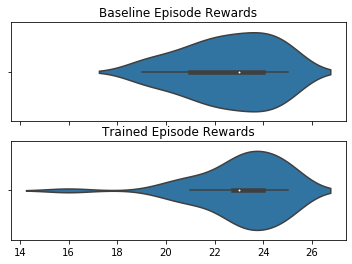

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.violinplot(rwds0, ax = axs[0])
axs[0].set_title('Baseline Episode Rewards')
sns.violinplot(rwds, ax = axs[1])
axs[1].set_title('Trained Episode Rewards')

In [23]:
base_per_agent-trained_per_agent

array([-0.008, -0.02 , -0.056,  0.004])

<BarContainer object of 4 artists>

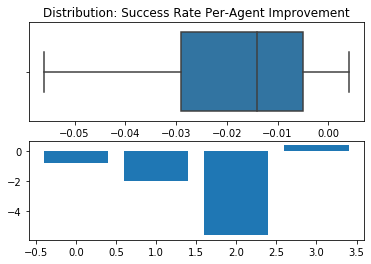

In [24]:
fig, axs = plt.subplots(2,1)
cmp = sns.boxplot(base_per_agent-trained_per_agent, ax = axs[0])
axs[0].set_title('Distribution: Success Rate Per-Agent Improvement');
axs[1].bar(x=range(len(exos)), height=100.*(base_per_agent-trained_per_agent))